In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
%matplotlib inline

# Principal Component Analysis (PCA)
## Motivation

Dimensionality reduction is a fundamental concept in machine learning, aiming to exploit relationships among points in high-dimensional space in order to construct some low-dimensional summaries. By doing so, this process eliminates redundancies, while preserving interesting characteristics of the data. In turn, we can use dimensional reduction techniques to extract interesting features and improve the computational tractability of downstream machine learning algorithms as well as to visualize data which are comprised of many interrelated variables. 

The idea of dimension reduction is really not new and dates back to Pearson(1901) and Hotelling (1933) who have invented principal component analysis (PCA). Today, PCA is the most widely used (linear) dimension reduction technique, due to its simple geometric interpretation. And all you need to know to understand PCA are some basic concepts from linear algebra. 

To gain some intution, let's consider an example in 2 dimensions. Here we consider two variables, $X_1$ which is the weight of each of $n=145$ students, and $X_2$ which is each student's corresponding height. We're interested in seeing how "related" the two variables are, e.g. in the sense that changes in the value of one variable "predict" changes in the value of the other variable. 

First, let's plot the sample points to get an idea of what we are working with.

In [2]:
np.random.seed(123)
x = np.random.standard_normal(size=145)*15 + 150 # weight (lbs)
y = 0.01 * x + np.random.standard_normal(size=145)*0.1 + 4 # height (ft)

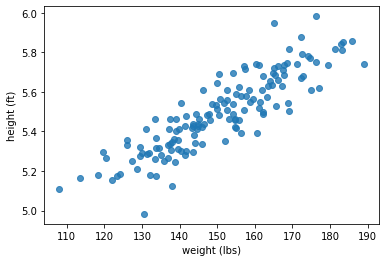

In [3]:
plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
plt.show()

In Ch 01 we briefly talked about how you can explore relationships between different variables. For instance, you might be interested in investigating whether there is a positive relationship between the height and weight of a person? From your Data 100 class you know that you can use the correlation coefficient to do so.

For instance, to quantify whether there is some relationship between height and weight we can compute the  (cosine of the) angle $ \gamma$ between two vectors to provide a notion of closeness. 

$$
 \gamma = \cos(\theta) = \frac{x \cdot y}{\|x\|_2\|y\|_2} .
$$

If we mean center both $x$ and $y$ in addition, we obtain Pearson's correlation coefficient $r_{xy}$

$$
 r_{xy} =  \frac{ (x-\bar{x}) \cdot (y-\bar{y})  }{\|x-\bar{x}\|_2\|y-\bar{y}\|_2},
$$

where $\bar{x}$ is the sample mean

$$ \bar{x} = \frac{1}{n} \sum_i x_i. $$

If you don't recall Pearson's correlation coefficient, check out this wiki: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient.

Okay, let's compute $r_{xy}$ for our data.

In [4]:
x -= x.mean() # mean center x
y -= y.mean() # mean center y
xy = x.dot(y) # compute dot product between x and y
x_norm = np.linalg.norm(x) # euclidean norm of x
y_norm = np.linalg.norm(y) # euclidean norm of y
r = xy / (x_norm * y_norm)
print(r)

0.8781109535909715


So the correlation coefficient indicates that there is a relationship between the height and weight, i.e., if you only know the weight of a person, you can make an educted guess about the person's height and vice versa. As closer the correlation coefficient tends towards 1 as stronger is the correlation. 

Now, another question that we could ask is whether we can form a new variable that summarizes both weight and hight. If you only have 2 variables, there might be no big gain, but assume you have a few hundrats of variables. In the latter case it is difficult to parse all the relationship between the many variables, and in this case finding variables that summarize most of the information in the data might be of great aid:

For now we stick to our 2 variable problem, but we will have a look at high-dimensional problems later.

First, we need to ask ourself how we can quantify the information content in variables. One way is to consider the variation of a variable as a measure the information content. In this case, we would like to find a linear combination of all the variables in our dataset 

$$ z = w_1 x_1 + w_2 x_2 + \dots + w_p x_p = Xw, $$

so that the new variable $z$ explains most of the variation in the data. So how can we maximize the variance of the variable z?

## Forumlating PCA as a Variance Maximization Problem 

First, let's construct the matrix $X$ so that we can take advantage of matrix computations.

In [5]:
X = np.vstack((x,y)).T
X.shape

(145, 2)

Recall, both $x$ and $y$ are mean centered! Now, we can formulate an optmization problem:

$$ w = \textit{argmax} \,\, \operatorname{Var}(z) =  \textit{argmax} \,\, \operatorname{Var}(X \tilde{w}) \quad \text{s.t.} \quad \|w\|_2^2=1 $$

where $\operatorname{Var}$ denotes the variance operator. We can define the variance operator as 

$$ \operatorname{Var}(M) = \frac{1}{n-1} \| M-\mu \|_2^2$$

where $\mu$ denotes the vector in $\mathbb{R}^d$ which contains the mean of each of the $d$ features. The notation $M - \mu$ in the equation above means that we subtract the vector $\mu$ from each column of $M$. In NumPy parlance things like this are called ["broadcasting"](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html). Here $n$ denotes the number of _observations_, and does **not** denote the number of features $d$.

Now, given the variance operator and noting that $X$ is already mean centered, we can rewrite $Var(X \tilde{w})$ as

$$ Var(X \tilde{w}) = \frac{1}{n-1} \| X \tilde{w} \|_2^2 = \frac{1}{n-1} w^T X^T X w = w^T C w $$

where $C := \operatorname{Cov(X)} = \frac{1}{n-1} X^T X$ is the $d \times d$ covariance matrix. Note, if $X$ where not mean centered, then we would need to use the following formula to compute the covariance matrix $C := \operatorname{Cov(X)} =\frac{1}{n} (X- \mu)(X- \mu)^\top \,. $


Now, plugging in $w^T C w$ into our maximiation problem we get:

$$ w = \textit{argmax} \,\, w^T C w \quad \text{s.t.} \quad \|w\|_2^2=1. $$

This problem can be solved via the the method of Lagrange multipliers. Therefore, we formulatethe Lagrange function

$$\mathcal{L}(w, \lambda) =  w^T C w - \lambda (w^T w -1). $$

Then, we maximize the Lagrange function by differentiating with respect to $w$


$$ \frac{\partial \mathcal{L}(w, \lambda)}{\partial w} = 2Cw - 2 \lambda w $$.

The last step might not be obvious, since we haven't dicussed matrix calculus. But if you are interested you can have a quick look here: https://en.wikipedia.org/wiki/Matrix_calculus. 


## It All Boils Down to an Eigenvalue Problem

Okay, wait a minute! The problem $Cw = \lambda w$ should look very familar to you by now. This is the eigenvalue problem that we have discussed already. Thus, it turns out at that the first principal direction for themean centered matrix $X$ is given by the dominant eigenvector $w$ of the covariance matrix $C$. Moreover, the amount of variation explained by $z=Xw$ is expressed by the corresponding eigenvalue $\lambda$.

More generally, the subsequent principal component directions can be obtained by computing the eigendecompositon of the covariance matrix:

$$ C = W\Lambda W^\top. $$

That is great, because you know alreay how to compute an eigen decomposition of a matrix in Python. So let's do it.

In [6]:
C = 1/(X.shape[0]-1) * X.T.dot(X)

In [7]:
Lambda, W = np.linalg.eig(C)

Okay, let's plot our mean centered data.

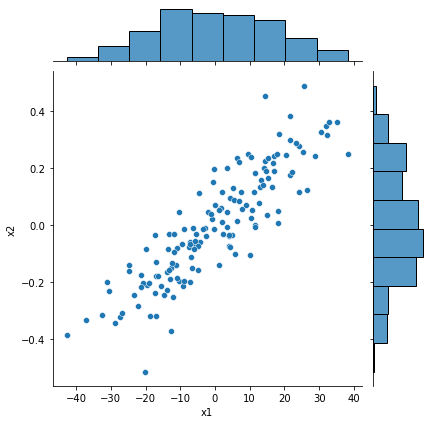

In [8]:
df = pd.DataFrame(data={'x1': X[:,0], 'x2': X[:,1]})
sns.jointplot(data=df, x="x1", y="x2")

Now, let's compute the $z$ and visualize the projected data.

In [9]:
Z = X.dot(W)

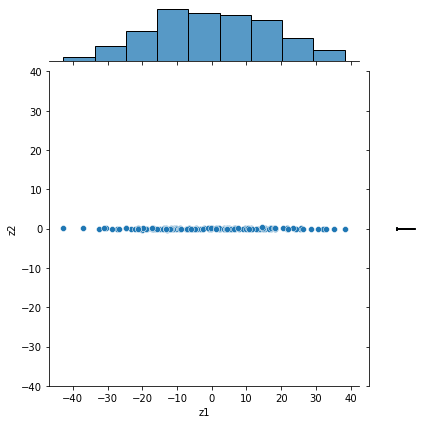

In [10]:
df = pd.DataFrame(data={'z1': Z[:,0], 'z2': Z[:,1]})
sns.jointplot(data=df, x="z1", y="z2")
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.show()

So, we can see that the first variable $z_1$ explains most of the variation in the data. We call this new variable also the first principal component and $w_1$ is the correpsonding principal direction.

## As a rule of thumb, always use the correlation matrix

Typically, it is a bad idea to decompose a covariance matrix if the variables do not have the same units. In some sense we compare apples and oranges here. Hence, in practice, it is always a good idea to work with the correlation matrix, instead of the covariance matrix. Here is how you compute the correlation matrix for the same problem.

In [11]:
x /= np.var(x)**0.5
y /= np.var(x)**0.5

In [12]:
X = np.vstack((x,y)).T
C = 1/(X.shape[0]-1) * X.T.dot(X)

In [13]:
Lambda, W = np.linalg.eig(C)

In [14]:
Z = X.dot(W)

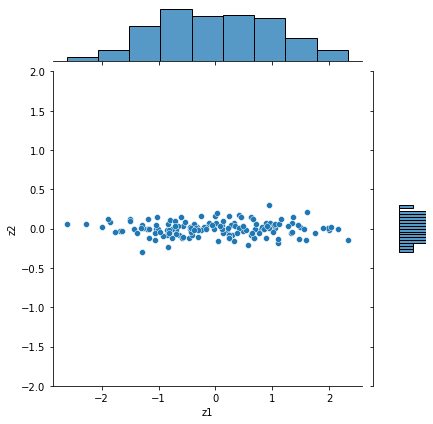

In [15]:
df = pd.DataFrame(data={'z1': Z[:,0], 'z2': Z[:,1]})
sns.jointplot(data=df, x="z1", y="z2")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

This plot is actually more plausible, i.e., we see that the second principal component is explaining a small amount of the variation. This is what we expect, since the correlation coefficient was only about $\approx 0.9$. 

## The role of the eigenvalues

Now that we have a low-dimensional representation of our data, you might ask how much of the variation do we explain by just considering $z_1$. We can have a look at the eigenvalues, which tell us the amount of variance captured by keeping only the first component

$$ \eta = \frac{\lambda_1}{\sum_{i=1}^p \lambda_i}. $$

In words, we compute the variation explained by the first principal component over the total variation in the data. 

In [16]:
Lambda[0] / np.sum(Lambda)

0.991878244303112

Here, we explain about 99% of the variation in the data by just keeping the first component. This is a lot!

In practice, it is often a subtle issue choosing a “good” number of principal components to retain. Little is gained by retaining too many components. Conversely, a bad approximation is produced if the number of retained components is too small. So the number components always depends on the specific application. Thus, it is not surprising that there have been many different heuristics been proposed, including heuristics like the scree plot and Kaiser criterion.  

If we denote the number of components to keep by $k$, then we can extend the above formula as follows:

$$ \eta = \frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^p \lambda_i}. $$

## Illustrating the principal directions

Now, let's have another look at the principal directions $w$. The principal directions are the eigenvectors of the covariance or correlation matrix. Since these two matrices are symmetric, we know that the eigenvectors are orthogonal to each other. Further, we know that the first eigenvector points into the directions that explains most of the variation, and the second eigenvector into the direction that explains most of the remaining variation. (This logic carries over to higher dimensional problems.) 

So let's plot the eigenvectors (here the eigenvectors are vectors in $\mathbb{R}^2$) to varify our intuition in 2-D.

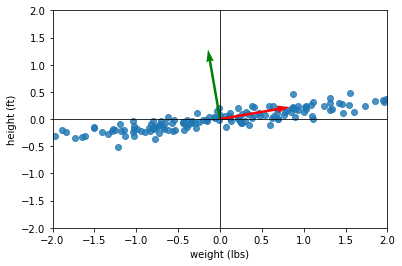

In [17]:
origin = np.array((0,0))
plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
plt.quiver(*origin, *W[:,0], color=['r'], scale=1, units='xy') # plot the vector v
plt.quiver(*origin, *W[:,1], color=['g'], scale=1, units='xy') # plot the vector v
plt.axhline(y=0, color='k', linestyle='-', lw=0.8)
plt.axvline(x=0, color='k', linestyle='-', lw=0.8)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The red arrow illustrates the first eigenvector (first principal direction) and the green arrow illustrates the second eigenvector (second principal direction).

## Why it is important to mean center (and normalize) the variables

Hopefully it should be clear from looking at this plot why we need to mean center the input data, before we compute the principal components and principal directions. Recall, the first principal component points in the directions that explains most of the variation! So here is a pathological example where things go wrong (by wrong we mean you don't get any meaningful interpreation) if you don't mean center the data. 

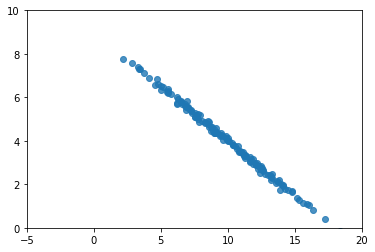

In [18]:
np.random.seed(123)
a =  np.random.standard_normal(size=145)*3  # weight (lbs)
b = 0.5 * a + np.random.standard_normal(size=145)*0.1 + 4 # height (ft)
a = a*-1 + 10

plt.scatter(a, b, alpha=0.8)
plt.xlim(-5,20)
plt.ylim(0,10)
plt.show()

Here the data are highly (negatively) correlated and it is plausible to reduce the dimensionality of the data using PCA.

In [19]:
X2 = np.vstack((a,b)).T
X2.shape

(145, 2)

In [20]:
print(np.corrcoef(X2, rowvar=False)[0,1]) # correlation coef. between x and y

-0.9984240517091183


The correlation coefficinet is almost -1, which indicates that the two variables are highly (negatlively) correlated. So let's look what happens if we compute PCA without  mean centering the data first.

In [21]:
Lambda, W = np.linalg.eig(X2.T.dot(X2))

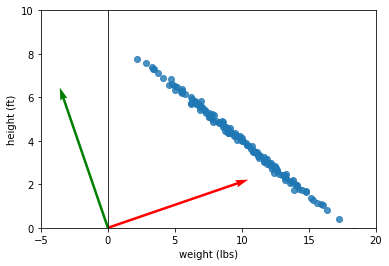

In [22]:
plt.scatter(a, b, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
plt.quiver(*origin, *W[:,0], color=['r'], scale=0.1, units='xy') # plot the vector v
plt.quiver(*origin, *W[:,1], color=['g'], scale=0.1, units='xy') # plot the vector v
plt.axhline(y=np.mean(y), color='k', linestyle='-', lw=0.8)
plt.axvline(x=np.mean(x), color='k', linestyle='-', lw=0.8)
plt.xlim(-5,20)
plt.ylim(0,10)
plt.show()

Clearly the first princiapl direction does not point into the direction that explains most of the variation. Thus, using these eigenvectors to form the new principal components is not meaningful, i.e., projecting all of our data points onto the line associated with the direction of the first principal direction does not have a meaningful interpreation. 

## Using the SVD to compute PCA

Typically, we prefer to compute the principal components and direction using the singular value decomposition (SVD). That is, because the SVD allows us to bypass the explicit construction of the covariance or correlation matrix. Instead, we compose the mean centered (and normalized) data matrix $X$ directly.

The SVD gives us the following decomposition 

$$ X = U S V^T$$

where $U$ and $V$ are matrices and their columns contain the left and right singular vectors, respectively. Further, $S$ is a diagonal matrix and its entries are the singular values. We have that $U^T U = I$ and $V^T V = I$. Now, it is easy to show that

$$ X^T X = (U S V^T)^T (U S V^T) = V S^2 V^T. $$

It follows that the eigenvalues are equal to the squared singular values and the right singular vectors $V$ correspond to the eigenvectors of the inner product $X^T X$. Importantly, we need to rescale the singular values by the factor $\frac{1}{n-1}$.

In [23]:
U, S, Vt = np.linalg.svd(X)

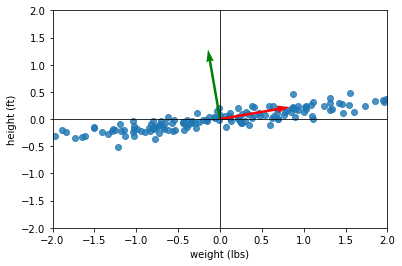

In [24]:
plt.scatter(x, y, alpha=0.8)
plt.xlabel("weight (lbs)")
plt.ylabel("height (ft)")
plt.quiver(*origin, *Vt.T[:,0], color=['r'], scale=1, units='xy') # plot the vector v
plt.quiver(*origin, *Vt.T[:,1]*-1, color=['g'], scale=1, units='xy') # plot the vector v
plt.axhline(y=0, color='k', linestyle='-', lw=0.8)
plt.axvline(x=0, color='k', linestyle='-', lw=0.8)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

It can be seen, that we obtain the same principal directions as before. And we can also use $V$ to project our input to obtain the principal components.

In [25]:
Z = X.dot(Vt.T)

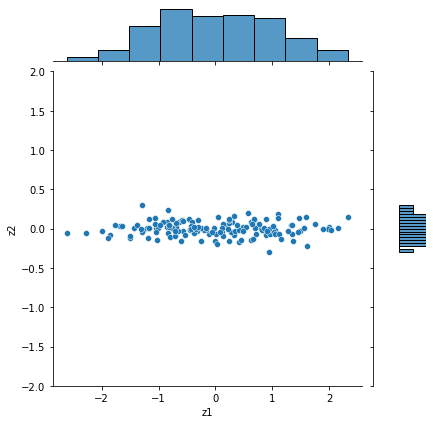

In [26]:
df = pd.DataFrame(data={'z1': Z[:,0], 'z2': Z[:,1]})
sns.jointplot(data=df, x="z1", y="z2")
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

## Application I: Embedding and Extracting Features from MNIST

In summary, the essential idea of PCA is to find a new set of uncorrelated variables
that retain most of the information present in the data. Let $\mathbf{X}$ be a scaled (mean centered/ standardized) matrix of dimension $m\times n$. The aim of PCA is to find a factorization in form of

\begin{equation}
	\begin{array}{cccccccccc}			
	\mathbf{X}  & \approx & \mathbf{Z} & \mathbf{W}^\top\\
	m\times n &   &  m\times k  & k\times n
	\end{array} 
\end{equation}

$\mathbf{Z}$ denotes the principal components, and $\mathbf{W}$ denotes the principal directions (eigenvectors).

Here we use PCA to extract features from handwritten digits to build a simple classifier.

### The Dataset

We load and visualize the first 25 hand-written digits in the dataset:

In [27]:
from sklearn.datasets import load_digits
digits, targets = load_digits(return_X_y=True)

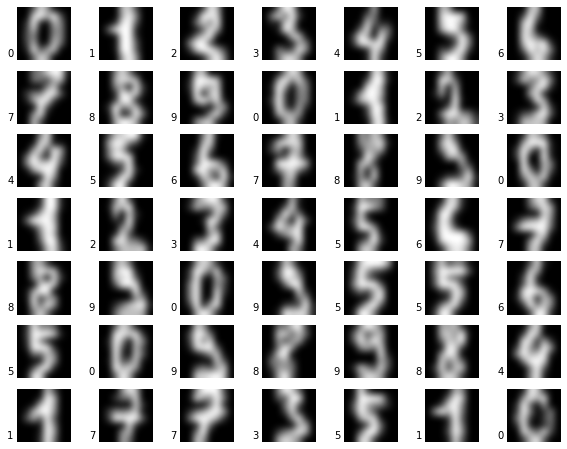

In [28]:
# set up the figure
fig, ax = plt.subplots(7,7,figsize=(10,8))
ax = ax.flatten()

index = 0
for axis in ax:
    axis.imshow(digits[index,:].reshape(8,8), cmap=plt.cm.gray, interpolation='bicubic')
    axis.text(-2, 7, str(int(targets[index])))
    axis.axis('off')
    index +=1
plt.show()

The data consists of 8×8 pixel images, meaning that they are 64-dimensional. Note, that this dataset is only a small subset of the MNIST database: http://yann.lecun.com/exdb/mnist/index.html.

### Compute Principal Components

To gain some intuition into the relationships between these points, we can use PCA to project them to low-dimensional space, say into a 2-dimensional space:

In [29]:
k=2

In the following we compute the randomized principal components via the randomized SVD. The first step requires us to mean center the data:

In [30]:
digits_mean = np.mean(digits, axis=0)

If you like, you can display the mean image:

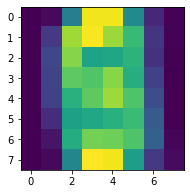

In [31]:
# plot the mean image
fig = plt.figure(figsize=(3, 3))
plt.imshow(digits_mean.reshape(8,8))
plt.show()

To compute the principal components of the covariance matrix via the SVD we need to center the data:

In [32]:
digits_centered = digits - digits_mean

Now, we can simply use the rsvd routine from the ristretto library to compute the principal directions (eigenvectors/ right singular vectors) $\mathbf{W}:=\mathbf{V}$:

In [33]:
U, s, Vt = np.linalg.svd(digits_centered, False)

In [34]:
Z = digits_centered.dot(Vt.T[:,0:k])
Z.shape

(1797, 2)

We can now plot the first two principal components of each point to learn about the data.

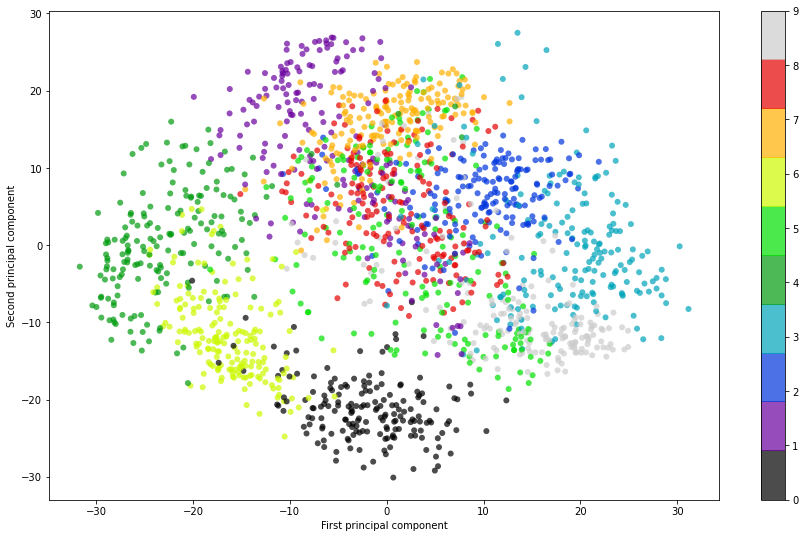

In [35]:
# Set up the figure
fig = plt.figure(figsize=(15, 9))

plt.scatter(Z[:,0], Z[:,1], c=targets, edgecolor='none', alpha=0.7, 
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar()
plt.show()

How much of the total variance is explained by the principal components? We need first to compute appropriately scale the singular values:

In [36]:
n_samles = Z.shape[0]
eigenvals = 1./(n_samles-1) * s**2

The eigenvalues are a measure for the explained variance. 

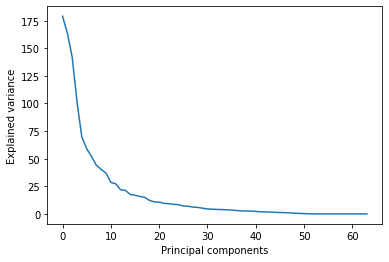

In [37]:
plt.plot(eigenvals)
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.show()

Now, we can plot the cumulative explained variance ratio:

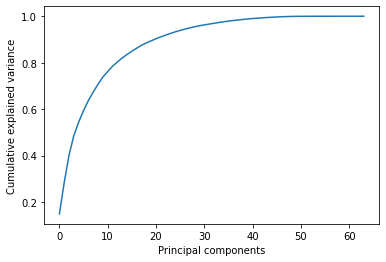

In [38]:
#total_variance = np.sum(np.var(digits_centered,axis=0))
total_variance = np.sum(eigenvals)
explained_variance_ratio = eigenvals / total_variance

plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

So the first two principal components account for about 

In [39]:
np.cumsum(explained_variance_ratio)[1]

0.285093648236993

of the total variance in the data.

You can also plot the basis functions:

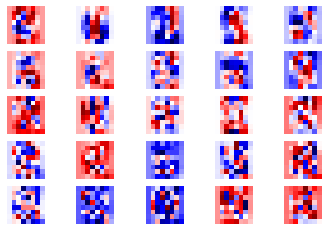

In [40]:
fig, ax = plt.subplots(5,5)
index = 0
for axis in ax.flatten():
        axis.imshow(Vt[index,:].reshape(8,8), cmap=plt.cm.seismic, interpolation='nearest')
        axis.axis('off')
        index +=1
plt.show()

### Handwritten Digit Classification

In the following we build a simple handwritten digit classifier using both random forest and k-nearest neighbors. 

To evaluate the classification performance later, we split the dataset into a trainings and test set:

In [41]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits, targets, random_state=0)

Again, we mean center the training data first:

In [42]:
Xtrain_mean = np.mean(Xtrain, axis=0)
Xtrain_centered = Xtrain - Xtrain_mean

Then, we compute the $k=40$ dominant principal components $\mathbf{Z}$ using the randomized SVD:

In [43]:
k=40

In [44]:
U, s, Vt = np.linalg.svd(Xtrain_centered, False)
Z = U[:,0:k] * s[0:k]
Z.shape

(1347, 40)

Note that we have the following relationship between the principal components and the left singular vectors
\begin{equation}
\mathbf{Z} = \mathbf{XW} = \mathbf{U \Sigma V}^\top \mathbf{W} = \mathbf{U \Sigma}. 
\end{equation}
Thus, in practice you can compute the principal components as:

### k-NN classifier

Next, we use k-nearest neighbors (https://it.wikipedia.org/wiki/K-nearest_neighbors) for classification. Again, we use the algorithm provided by the sklearn library (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) and we chose n_neighbors=5:

In [45]:
from sklearn.neighbors import KNeighborsClassifier
model_neigh = KNeighborsClassifier(n_neighbors=5)
model_neigh.fit(Z, ytrain)

KNeighborsClassifier()

Next, we use the model to predict the classes of the test samples. But first we need to mean center the test data points and also project them onto the top $k$ principal directions.

In [46]:
# Substract mean from test set
Xtest_centered = Xtest - Xtrain_mean

# Project mean centered test set to low-dimensional space
Z_test = Xtest_centered.dot(Vt.T[:,0:k])

In [47]:
Z_test.shape

(450, 40)

In [48]:
ypred = model_neigh.predict(Z_test)

And here is the performance of k-nearest neighbors technique:  

In [49]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.98      0.98      0.98        43
           2       0.98      1.00      0.99        43
           3       1.00      0.94      0.97        48
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.92      1.00      0.96        44
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Using the k-NN classifier in combination with the top $k=40$ principal components, we achieve about 98% accuracy.

## Application II: Eigenfaces

Next, we consider a dataset that contains a set of face images taken between 1992 and 1994 at AT&T Laboratories Cambridge. As described on the original website: "There are ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement)."

In [50]:
from sklearn.datasets import fetch_olivetti_faces
faces, targets = fetch_olivetti_faces(return_X_y=True, shuffle=True)

We can visualize a few of the faces, as follows.

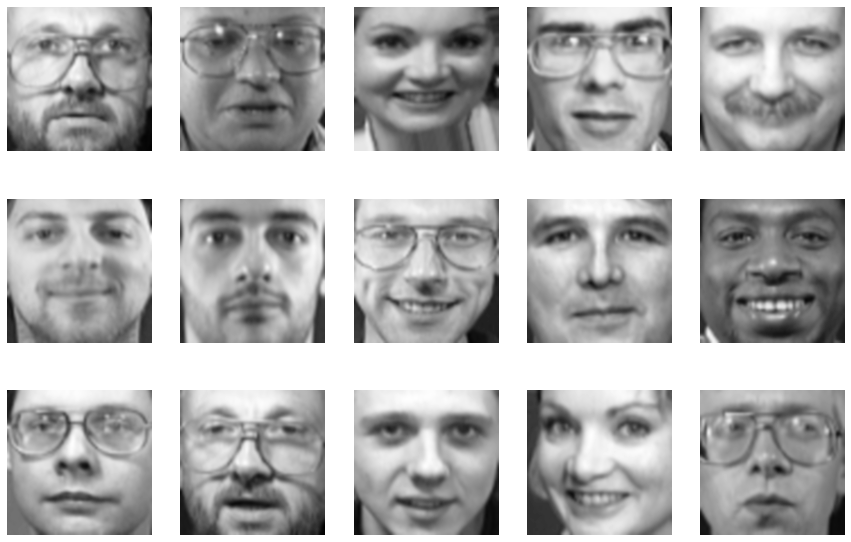

In [51]:
# set up the figure
fig, ax = plt.subplots(3,5, figsize=(15,10))
ax = ax.flatten()

index = 0
for axis in ax:
    axis.imshow(faces[index,:].reshape(64,64), cmap=plt.cm.gray, 
                interpolation='bicubic')
    axis.axis('off')
    index +=1
plt.show()

First, we mean center our dataset. But first let's have a look at the shape of the data.

In [52]:
faces.shape

(400, 4096)

We can see that each row contains a flattened face image (4096=64*64). Thus, we compute the mean along the first axis.

In [53]:
faces_mean = faces.mean(axis=0)

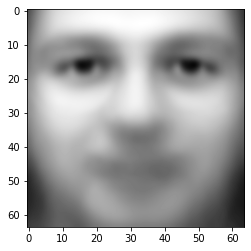

In [54]:
plt.imshow(faces_mean.reshape(64,64), cmap=plt.cm.gray, interpolation='bicubic')
plt.show()

Now, we can meancenter the data matrix.

In [55]:
X_centered = (faces - faces_mean)

We use the SVD to compute the principal directions.

In [56]:
u, s, vt = np.linalg.svd(X_centered, False)

In [57]:
vt.shape

(400, 4096)

The princiapl directions are the right singular vectors, which corresponds to the eigenvectors of the covariance matrix. Since these princiapl directions have the same length as the flattened face images, we can resahpe them and plot them as the face images above.

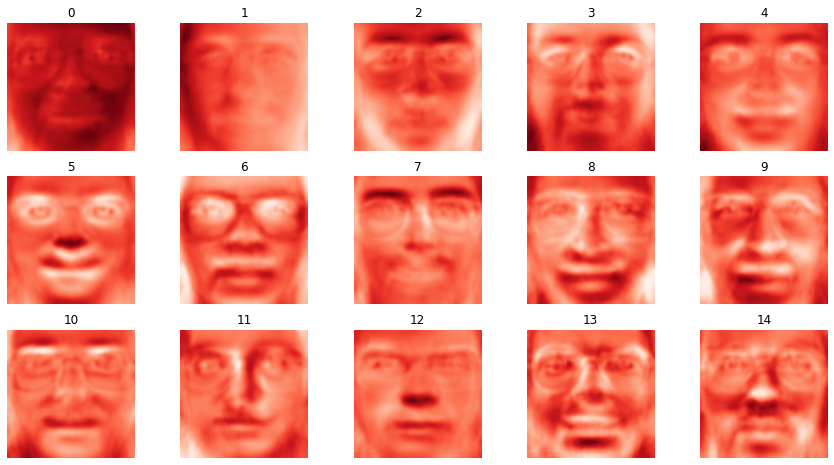

In [58]:
# set up the figure
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.flatten()

index = 0
for axis in ax:
    vmax = np.max(np.abs(vt[index,:]))
    axis.imshow(vt[index,:].reshape(64,64), cmap=plt.cm.Reds, interpolation='bicubic', vmin=-vmax, vmax=vmax)
    axis.axis('off')
    axis.set_title(index)
    index +=1
plt.show()

You can see that the different eigenvalues describe different facial features, such as the eys, eye browns, nose, and glasses (okay, glasses are not really a facial feature but PCA can't tell).

You can think about these eigendirection as a basis that we can use to approximate faces. To illustrate that, we pick one face and first project it to low-dimensional space and then back to the the original space using an increasing number of eigenvectors.

Here is an image that we use.

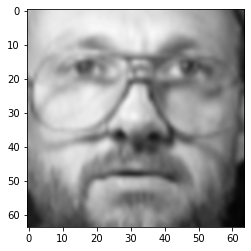

In [59]:
face = X_centered[0]
plt.imshow((face + faces_mean).reshape(64,64), cmap=plt.cm.gray, interpolation='bicubic')
plt.show()

Now we project and reconstruct the image as

$$ x = xV_kV_k^T $$

where we slowly increase the number of eigen directions $k$ that we use, i.e., $V[:\,, \,0:k]$.

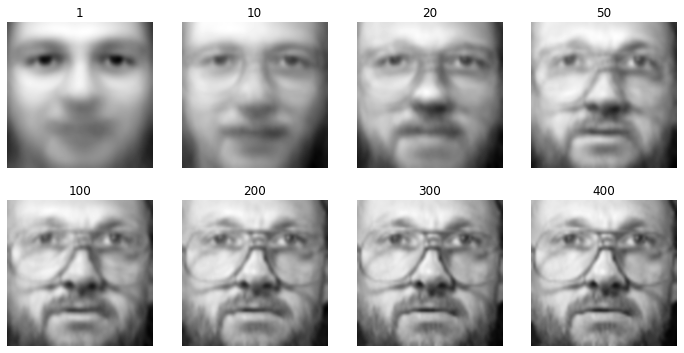

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
axs = axs.flatten()
idx = 0
for i in [1,10,20,50,100,200,300,400]:
    reconstruction = face.reshape(1,-1).dot(vt.T[:,0:i]).dot(vt[0:i,:]) + faces_mean
    axs[idx].imshow(reconstruction.reshape(64,64), cmap=plt.cm.gray, interpolation='bicubic')
    axs[idx].set_title(i)
    axs[idx].axis('off')
    idx += 1

You can see that we need to use only about $200$ eigenvectors to accurately reconstruct the image. If you use only about $50$ eigenvectors, you still can recognize the face while you have roughly removed the glasses.

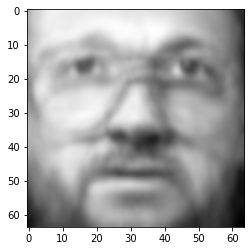

In [61]:
idx = np.arange(0,50)

reconstruction = face.reshape(1,-1).dot(vt.T[:,idx]).dot(vt[idx,:]) 
reconstruction = reconstruction.reshape(1,-1).dot(vt.T[:,idx]).dot(vt[idx,:])
reconstruction = reconstruction.reshape(1,-1).dot(vt.T[:,idx]).dot(vt[idx,:]) + faces_mean

plt.imshow(reconstruction.reshape(64,64), cmap=plt.cm.gray, interpolation='bicubic')